<a href="https://colab.research.google.com/github/chaimaGhouili/Edge_AI_Computer_Vision_Engineer/blob/main/reconaissancce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
from collections import defaultdict
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files


In [ ]:
# Upload du fichier zip depuis ton PC
uploaded = files.upload()  # Sélectionner faces.zip

# Récupérer le nom du fichier uploadé
zip_name = list(uploaded.keys())[0]
zip_path = f"/content/{zip_name}"


Saving faces.zip to faces.zip


In [ ]:
# Décompression du zip dans /content/
!unzip -q "{zip_path}" -d /content/

# Définir le chemin du dossier racine (ici 'faces')
dataset_path = "/content/faces"

# Vérifier le contenu du dossier racine
print("Sous-dossiers dans faces :", os.listdir(dataset_path))


Sous-dossiers dans faces : ['ameni', 'chaima', 'nerimen']


In [ ]:
def count_images(dataset_path):
    counts = {}
    for person in os.listdir(dataset_path):
        person_folder = os.path.join(dataset_path, person)
        if os.path.isdir(person_folder):
            imgs = [f for f in os.listdir(person_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            counts[person] = len(imgs)
    return counts


Nombre d'images avant augmentation : {'ameni': 20, 'chaima': 56, 'nerimen': 40}


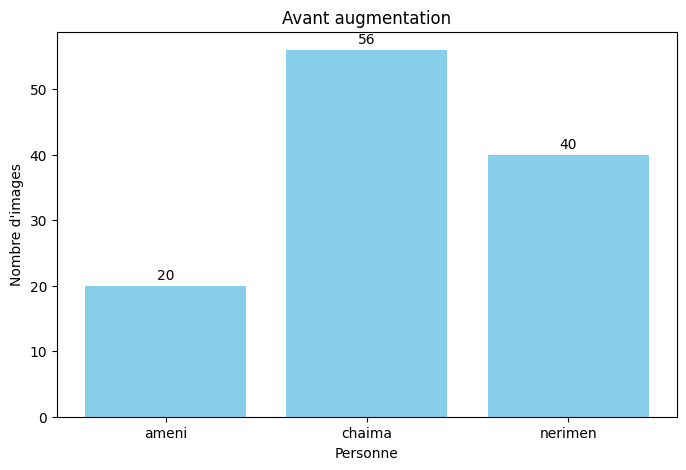

In [ ]:
def plot_counts(counts, title="Nombre d'images par personne"):
    persons = list(counts.keys())
    num_images = list(counts.values())
    plt.figure(figsize=(8,5))
    bars = plt.bar(persons, num_images, color='skyblue')
    plt.xlabel("Personne")
    plt.ylabel("Nombre d'images")
    plt.title(title)
    for bar, n in zip(bars, num_images):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(n), ha='center', va='bottom')
    plt.show()

# Compter et visualiser avant augmentation
counts_before = count_images(dataset_path)
print("Nombre d'images avant augmentation :", counts_before)
plot_counts(counts_before, title="Avant augmentation")


In [ ]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)


In [ ]:
# Déterminer le nombre cible = nombre max d'images
target_count = max(counts_before.values())

for person, count in counts_before.items():
    person_folder = os.path.join(dataset_path, person)
    imgs = [f for f in os.listdir(person_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    num_to_generate = target_count - count
    if num_to_generate <= 0:
        continue  # déjà équilibré

    print(f"Augmenter {person} de {num_to_generate} images")
    i = 0
    while i < num_to_generate:
        for img_name in imgs:
            if i >= num_to_generate:
                break
            img_path = os.path.join(person_folder, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.expand_dims(img, axis=0)

            aug_iter = datagen.flow(img, batch_size=1)
            aug_img = next(aug_iter)[0].astype(np.uint8)
            aug_img_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)

            # Sauvegarder l'image augmentée
            aug_filename = f"aug_{i}_{img_name}"
            cv2.imwrite(os.path.join(person_folder, aug_filename), aug_img_bgr)
            i += 1


Augmenter ameni de 36 images
Augmenter nerimen de 16 images


Nombre d'images après augmentation : {'ameni': 56, 'chaima': 56, 'nerimen': 56}


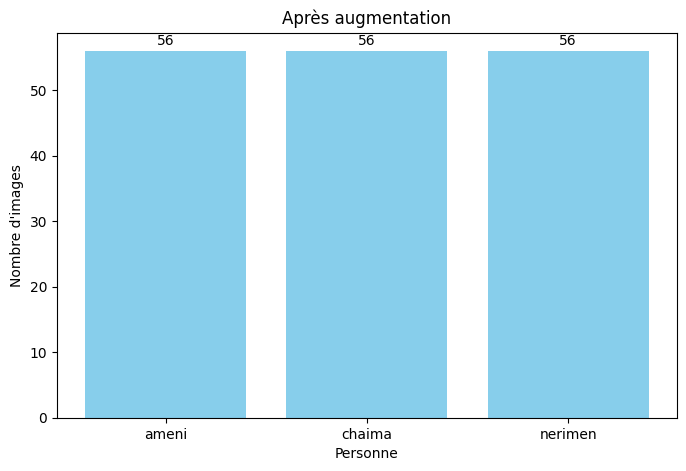

In [ ]:
# Compter et visualiser après augmentation
counts_after = count_images(dataset_path)
print("Nombre d'images après augmentation :", counts_after)
plot_counts(counts_after, title="Après augmentation")


In [ ]:
# Désinstaller Pillow et facenet-pytorch si elles causent problème
!pip uninstall -y pillow facenet-pytorch

# Réinstaller les bonnes versions
!pip install --upgrade pillow
!pip install facenet-pytorch


Found existing installation: pillow 10.2.0
Uninstalling pillow-10.2.0:
  Successfully uninstalled pillow-10.2.0
Found existing installation: facenet-pytorch 2.6.0
Uninstalling facenet-pytorch-2.6.0:
  Successfully uninstalled facenet-pytorch-2.6.0
  Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (8.8 kB)
Using cached pillow-12.0.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gradio 5.49.1 requires pillow<12.0,>=8.0, but you have pillow 12.0.0 which is incompatible.


  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.7 kB)
Using cached facenet_pytorch-2.6.0-py3-none-any.whl (1.9 MB)
Using cached pillow-10.2.0-cp312-cp312-manylinux_2_28_x86_64.whl (4.5 MB)
  Attempting uninstall: Pillow
    Found existing installation: pillow 12.0.0
    Uninstalling pillow-12.0.0:
      Successfully uninstalled pillow-12.0.0


In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image
import torch



In [ ]:
dataset_path = "/content/faces"

# Dossier où les visages recadrés seront sauvegardés
aligned_folder = "/content/faces_aligned_corrigee"
os.makedirs(aligned_folder, exist_ok=True)

# Initialiser MTCNN
mtcnn = MTCNN(image_size=160, margin=10)

In [ ]:
for person in os.listdir(dataset_path):
    person_folder = os.path.join(dataset_path, person)
    save_person_folder = os.path.join(aligned_folder, person)
    os.makedirs(save_person_folder, exist_ok=True)

    for img_name in os.listdir(person_folder):
        if not img_name.lower().endswith(('.jpg','.jpeg','.png')):
            continue

        img_path = os.path.join(person_folder, img_name)
        img = Image.open(img_path).convert('RGB')

        # Détecter et recadrer le visage
        face = mtcnn(img)
        if face is not None:
            # Convertir tensor en image correctement (0-255)
            face_img = (face.permute(1,2,0).numpy() * 255).astype('uint8')
            # Ajouter un préfixe pour éviter l'écrasement
            save_path = os.path.join(save_person_folder, "aligned_" + img_name)
            Image.fromarray(face_img).save(save_path)

print("Détection et recadrage terminés. Visages sauvegardés dans 'faces_aligned_corrigee'.")



Détection et recadrage terminés. Visages sauvegardés dans 'faces_aligned_corrigee'.


In [ ]:
from facenet_pytorch import InceptionResnetV1


In [ ]:
# MobileNet-FaceNet pré-entraîné
model = InceptionResnetV1(pretrained='vggface2').eval()  # eval() désactive le dropout


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
def get_embedding(face_img):
    """
    face_img : PIL.Image ou numpy array 160x160x3
    retourne : vecteur 512D
    """
    # Si c’est un PIL Image, convertir en numpy
    if isinstance(face_img, Image.Image):
        face_img = np.array(face_img)

    # Convertir en tensor et normaliser
    face_tensor = torch.tensor(face_img / 255.0, dtype=torch.float32)  # valeurs 0-1
    face_tensor = face_tensor.permute(2,0,1).unsqueeze(0)  # 1x3x160x160

    with torch.no_grad():
        embedding = model(face_tensor)  # tensor 1x512
    return embedding.squeeze(0).numpy()  # array 512D


In [ ]:


aligned_folder = "/content/faces_aligned_corrigee"
embeddings_dict = {}

# Parcourir chaque personne
for person in os.listdir(aligned_folder):
    person_folder = os.path.join(aligned_folder, person)
    embeddings_person = []

    for img_name in os.listdir(person_folder):
        if not img_name.lower().endswith(('.jpg','.jpeg','.png')):
            continue

        img_path = os.path.join(person_folder, img_name)
        img = Image.open(img_path).convert('RGB')

        embedding = get_embedding(img)
        embeddings_person.append(embedding)

    embeddings_dict[person] = np.array(embeddings_person)

# Sauvegarder tous les embeddings et noms dans un seul fichier
np.save("all_embeddings.npy", embeddings_dict)
print("Tous les embeddings ont été sauvegardés dans 'all_embeddings.npy'.")


Tous les embeddings ont été sauvegardés dans 'all_embeddings.npy'.
